In [29]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [7]:
base_dir = r'C:\Users\shail\Desktop\NSL\NSL RGB' 

categories = sorted(os.listdir(base_dir))
print(f"Categories: {categories}")

Categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [26]:
img_height = 224     # Desired image height
img_width = 224     # Desired image width
batch_size = 32
split_ratio = 0.2   # 20% for validation, 80% for training
num_classes = 10    # Total number of categories (0-9)

# Load training set (80%)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",                # Labels inferred from folder names
    label_mode="categorical",                 # Labels as integers initially
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=split_ratio,
    subset="training"
)

# Load validation set (20%)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=split_ratio,
    subset="validation"
)


Found 8085 files belonging to 10 classes.
Using 6468 files for training.
Found 8085 files belonging to 10 classes.
Using 1617 files for validation.


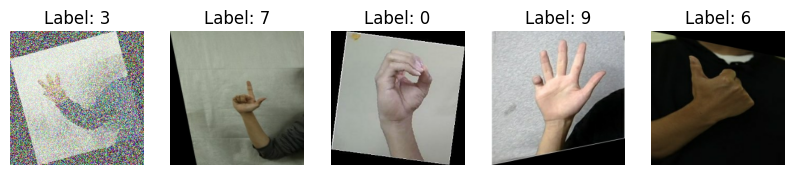

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Take one batch of images
    for i in range(5):                        # Display the first 10 images
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
plt.show()

In [31]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Optionally freeze some layers
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Adjust this number as necessary
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # For 10 classes of hand gestures

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_3[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_60[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_57[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_60[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_58 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_58[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,244,938 (12.38 MB)

 Trainable params: 1,843,306 (7.03 MB)

 Non-trainable params: 1,401,632 (5.35 MB)

In [33]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.1208 - loss: 2.3805 - val_accuracy: 0.1571 - val_loss: 2.2931 - learning_rate: 1.0000e-05
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.3783 - loss: 1.8509 - val_accuracy: 0.2962 - val_loss: 1.8086 - learning_rate: 1.0000e-05
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.5544 - loss: 1.4352 - val_accuracy: 0.4954 - val_loss: 1.3673 - learning_rate: 1.0000e-05
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.6679 - loss: 1.1397 - val_accuracy: 0.6246 - val_loss: 1.0558 - learning_rate: 1.0000e-05
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.7519 - loss: 0.9036 - val_accuracy: 0.7143 - val_loss: 0.8442 - learning_rate: 1.0000e-05
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.8049 - loss: 0.7361 - val_accuracy: 0.7755 - val_loss: 0.6876 - learning_rate: 1.0000e-05
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - acc

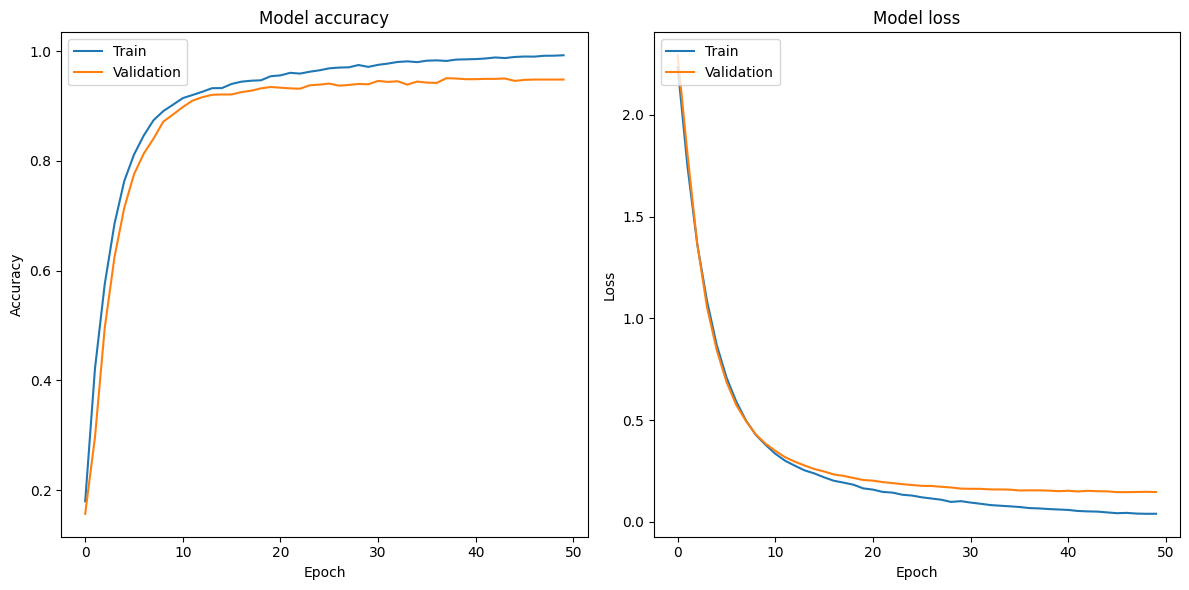

In [34]:
# plotting the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()

In [35]:
model.save('MobileNetV3Large.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


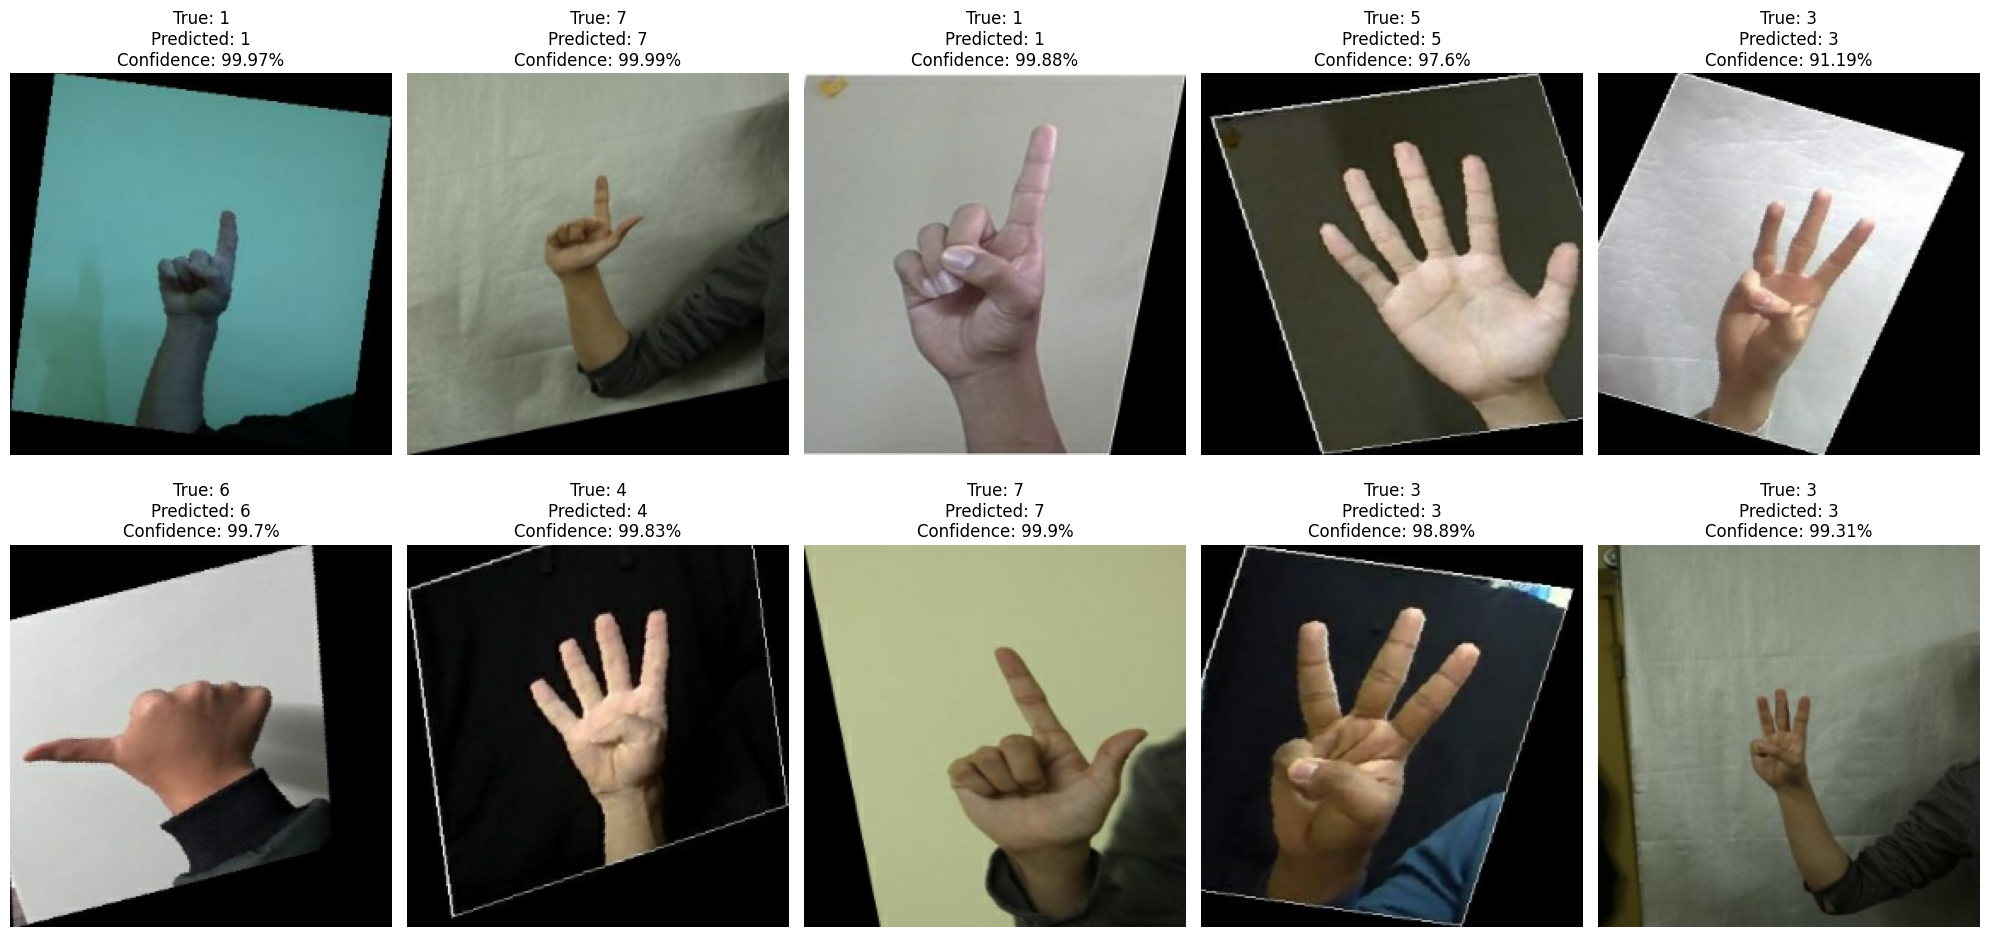

In [36]:
def display_predictions(model, validation_dataset, class_names, num_images=10):

    images, labels = next(iter(validation_dataset))
    
    random_indices = np.random.choice(len(images), size=num_images, replace=False)

    plt.figure(figsize=(20, 10))  

    for i, index in enumerate(random_indices):
        image = images[index].numpy()
        true_label = labels[index].numpy()  

        img_array = np.expand_dims(image, axis=0)
        predictions = model.predict(img_array)

        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * np.max(predictions[0]), 2)

        plt.subplot(2, 5, i + 1) 
        plt.axis('off')
        plt.imshow(image.astype('uint8'))  
        plt.title(f"True: {class_names[np.argmax(true_label)]}\nPredicted: {predicted_class}\nConfidence: {confidence}%")

    plt.tight_layout()  
    plt.show()

class_names = validation_dataset.class_names 
display_predictions(model, validation_dataset, class_names, num_images=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

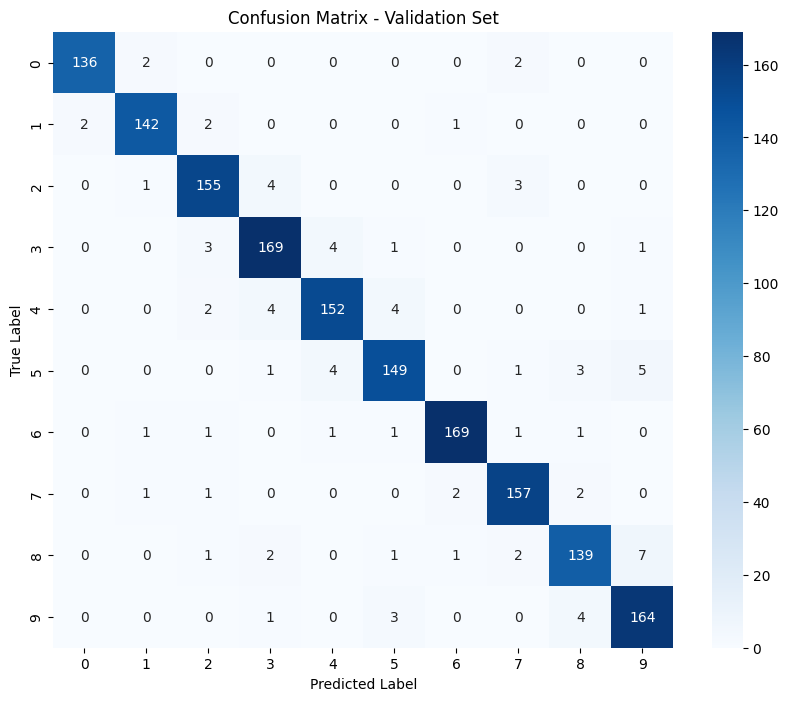

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       140
           1       0.97      0.97      0.97       147
           2       0.94      0.95      0.95       163
           3       0.93      0.95      0.94       178
           4       0.94      0.93      0.94       163
           5       0.94      0.91      0.93       163
           6       0.98      0.97      0.97       175
           7       0.95      0.96      0.95       163
           8       0.93      0.91      0.92       153
           9       0.92      0.95      0.94       172

    accuracy                           0.95      1617
   macro avg       0.95      0.95      0.95      1617
weighted avg       0.95      0.95      0.95      1617



In [37]:
def calculate_validation_confusion_matrix(model, validation_dataset):
    y_true = []
    y_pred = []

    for images, labels in validation_dataset:
        predictions = model.predict(images)  # Get model predictions
        y_true.extend(np.argmax(labels.numpy(), axis=1))  # True labels
        y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

    cm = confusion_matrix(y_true, y_pred)
    
    return y_true, y_pred, cm


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

def display_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)


class_names = validation_dataset.class_names  # Get class names from the dataset

y_true, y_pred, validation_cm = calculate_validation_confusion_matrix(model, validation_dataset)


print("Confusion Matrix for Validation Set:")
print(validation_cm)

plot_confusion_matrix(validation_cm, class_names)

display_classification_report(y_true, y_pred, class_names)
